In [5]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [6]:
V2_2 = np.loadtxt('data/data_10_08/V1_V2/data_V2.csv', delimiter=',', skiprows=3)
V2_3 = np.loadtxt('data/data_10_08/V1_V3/data_V3.csv', delimiter=',', skiprows=3)
V2_4 = np.loadtxt('data/data_10_08/V1_V4/data_V4.csv', delimiter=',', skiprows=3)
V2_5 = np.loadtxt('data/data_10_08/V1_V5/data_V5.csv', delimiter=',', skiprows=3)
V2_6 = np.loadtxt('data/data_10_08/V1_V6/data_V6.csv', delimiter=',', skiprows=3)
V2_7 = np.loadtxt('data/data_10_08/V1_V7/data_V7.csv', delimiter=',', skiprows=3)
V2_8 = np.loadtxt('data/data_10_08/V1_V8/data_V8.csv', delimiter=',', skiprows=3)
V2_9 = np.loadtxt('data/data_10_08/V1_V9/data_V9.csv', delimiter=',', skiprows=3)
V2_10 = np.loadtxt('data/data_10_08/V1_V10/data_V10.csv', delimiter=',', skiprows=3)

In [7]:
delta_V = np.concatenate((V2_2[:, 1:], V2_3[:, 1:], V2_4[:, 1:], V2_5[:, 1:], V2_6[:, 1:], V2_7[:, 1:], V2_8[:, 1:], V2_9[:, 1:], V2_10[:, 1:]), axis=1)
#delta_V_1 = np.concatenate((V10_2[:, 1:], V10_3[:, 1:], V10_4[:, 1:], V10_5[:, 1:], V10_6[:, 1:], V10_7[:, 1:], V10_8[:, 1:], V10_9[:, 1:], V10_10[:, 1:]), axis=1)

In [64]:
delta_V.shape

(4064, 6)

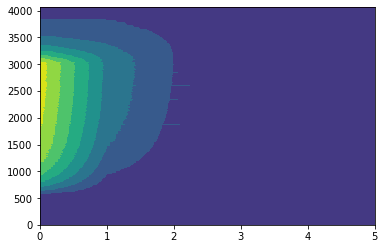

In [65]:
#plt.figure(figsize=(6, 6))
#plt.subplot(121)
plt.contourf(delta_V[:,:])

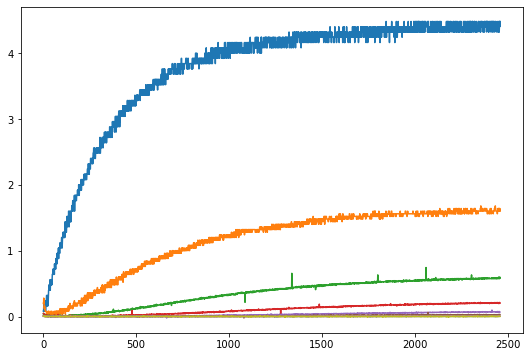

In [66]:
plt.figure(figsize=(9, 6))
plt.plot(V2_2[540:3000, 1])
plt.plot(V2_3[540:3000, 1])
plt.plot(V2_4[540:3000, 1])
plt.plot(V2_5[540:3000, 1])
plt.plot(V2_6[540:3000, 1])
plt.plot(V2_7[540:3000, 1])
plt.plot(V2_8[540:3000, 1])
plt.plot(V2_9[540:3000, 1])
plt.plot(V2_10[540:3000, 1])

In [67]:
# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [68]:
output_data = delta_V[540:3000,:].T
output_data.shape

(6, 2460)

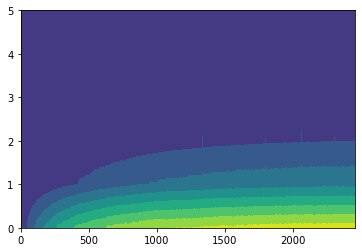

In [69]:
plt.contourf(output_data[:,:])

In [70]:
x = np.linspace(0, 1, output_data.shape[0])
t = np.linspace(0, 1, output_data.shape[1])

In [71]:
x

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [72]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [73]:
np.max(output_data)

4.48

In [74]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(output_data).reshape((output_data.size, 1))

In [75]:
y.shape

(14760, 1)

In [76]:
y = y/np.max(y)

In [77]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [78]:
network = NN(2, [50, 50, 50, 50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [79]:
library = Library1D(poly_order=1, diff_order=2) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [80]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [81]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [82]:
model = DeepMoD(network, library, estimator, constraint)

In [83]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [62]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/Akshay_small-/', split=0.8, max_iterations=100000, delta=0.1e-6, patience=100) 

 10925  MSE: 9.36e-05  Reg: 9.29e-06  L1: 1.00e+00 Algorithm converged. Writing model to disk.


In [45]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=1, diff_order=2) # Library function
estimator = Threshold(0.01) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

In [32]:
# Running model
sparsity_scheduler = Periodic(periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [33]:
train(model, X_train, y_train, optimizer, sparsity_scheduler,delta=0.002) # Running

TypeError: can only concatenate str (not "NoneType") to str

In [31]:
train(model, X_train, y_train, optimizer, sparsity_scheduler,delta=0.0001, max_iterations = 100000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      99975     99.98%               1s   -1.49e+01   9.45e-05   7.77e-08   1.14e+01 [tensor([True, True, True, True, True, True])]
     100000    100.00%               0s   -1.49e+01   9.45e-05   7.80e-08   1.14e+01 

In [32]:
train(model, X_train, y_train, optimizer, sparsity_scheduler,delta=0.0001, max_iterations = 100000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      99975     99.98%               1s   -1.49e+01   9.05e-05   2.18e-06   1.37e+01 [tensor([True, True, True, True, True, True])]
     100000    100.00%               0s   -1.49e+01   9.05e-05   2.49e-06   1.37e+01 

In [33]:
train(model, X_train, y_train, optimizer, sparsity_scheduler,delta=0.0001, max_iterations = 100000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      99975     99.98%               1s   -1.50e+01   8.77e-05   2.95e-06   2.22e+01 [tensor([True, True, True, True, True, True])]
     100000    100.00%               0s   -1.50e+01   8.77e-05   1.32e-06   2.22e+01 

In [34]:
train(model, X_train, y_train, optimizer, sparsity_scheduler,delta=0.0001, max_iterations = 100000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      86050     86.05%             617s   -1.50e+01   8.71e-05   1.56e-06   2.75e+01 

KeyboardInterrupt: 